<a href="https://colab.research.google.com/github/alexapruiz/Projetos/blob/master/Aula_031_Algoritmos_Gen%C3%A9ticos_com_DEAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="center"><img src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/eds.png" height="100px"></p>

# Aula 031 - Resolvendo um problema de otimização com Algoritmos Genéticos

---
**Otimização** pode ser entendido como **a busca da melhor solução para um certo problema**. De acordo com Lacerda (1999), as técnicas de busca e otimização, normalmente, apresentam estas duas características:

* Um espaço de busca - que é onde se encontram todas as possíveis soluções; e
* Uma função objetivo - que é como nós avaliamos a qualidade da solução encontrada. Por vezes, na literatura sobre GA, também é conhecida como *fitness*.

<p align="center"><img src="https://deap.readthedocs.io/en/master/_images/deap_long.png" width="60%"></p>

Para demonstrar o funcionamento de um GA básico, vamos considerar o seguinte problema:

$$\text{Maximizar: } f(x) = x\text{sen}(10 \pi x) + 1$$
$$\text{Sujeito a: } -1 \leq x \leq 2 $$

Embora seja uma função que contém apenas uma variável, e seja aparentemente simples, ela é ótima para entender o conceito que torna os GA tão poderosos para problemas de otimização.

Bem, vamos plotar a função para ver o aspecto da mesma.

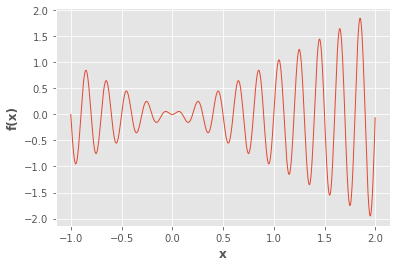

In [ ]:
# Apenas importando algumas bibliotecas úteis
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import random
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

x = np.arange(-1, 2, 0.001)    # gerando valores dentro do intervalo do problema
y = x * np.sin(10 * np.pi * x)          # representação da função objetivo f(x) = x*sen(4*x)

# Plotar o gráfico da função objetivo
def plotar_funcao_objetivo():
    """Plota o gráfico da função objetivo."""
    plt.plot(x, y, linewidth=1)
    plt.xlabel('x', fontweight="bold")
    plt.ylabel('f(x)', fontweight="bold")
    return None

plotar_funcao_objetivo()
plt.show()

Apesar da função ser aparentemente simples, trazem uma característica que é extremamente prejudicial à resolução por métodos de otimização tradicionais. Como estes são dependentes do ponto de inicialização do problema, estão sujeitos a cairem dentro de ótimos locais.

Na terminologia própria dos GA, um indivíduo ou cromossomo representa uma solução para o problema. Um cromossomo é uma estrutura de dados (geralmente **vetor** ou **cadeia de bits**) que representa uma possível solução para o problema.

Cada cromossomo possui genes, que são os elementos do vetor. Assim como na biologia, os genes são as unidades básicas de hereditariedade na qual passamos as características de um indivíduo para outro.

## O Algoritmo Genético Simples (SGA)

O SGA é a proposta original dos GA, e será utilizado para buscar a melhor solução (maior valor para $f(x)$) do nosso problema. O fluxograma de um SGA segue como na figura abaixo **(Fonte: SOUZA, 2017)**.

<center><img src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/fluxograma.png"></center>

Seguem alguns conceitos importantes para trabalharmos no nosso SGA:

**SGA - Representação:** Codificação binária. Ou seja, uma string de bits codifica as variáveis e representa um indivíduo - que é uma solução candidata.

**Precisão Numérica:** Quanto mais genes nosso cromossomo tiver, maior será a sua precisão.
Para o nosso exemplo, vou utilizar uma cadeia de 16 bits.

Para gerar um indivíduo, em codificação binária, basta que geremos uma *string* do tamanho da precisão escolhida. Para isso, vou criar uma função específica e gerar um cromossomo de exemplo:

In [ ]:
np.random.seed(11)

def gerar_individuo():
    """Função para gerar um indivíduo de 16 bits."""
    ind = np.random.randint(0, 2, 16, dtype=int)
    return ind

individuo = gerar_individuo()
print(individuo)

[1 1 0 1 1 1 1 0 1 1 0 0 1 0 0 1]


Foi gerado o cromossomo **c1 = 1101111011001001**, que contém 16 genes. Entretanto, o cromossomo está codificado, e não parece tão útil. 

Para sermos capazes de avaliar o mesmo (solução boa/solução ruim) em relação à função objetivo, é necessário:
* **converter de binário para decimal**; e 
* **mapear o cromossomo para o intervalo do problema** [-1, 2].


In [ ]:
# binario para decimal
int('0b1101111011001001'[2:], 2)

57033

In [ ]:
# decimal para binario
bin(57033)

'0b1101111011001001'

Temos agora que o nosso cromossomo *1101111011001001* é equivalente ao valor *57033*. 

Ou seja, $ x = 57033$.

## Mapear o Cromossomo para o intervalo do problema


Mas, lembrando a restrição do nosso modelo, $x$ deve pertencer ao intervalo $ [-1, 2]$. Agora é a hora de mapear o cromossomo para o intervalo do problema seguindo a seguinte fórmula:

$$
x = \text{min} + (\text{max} - \text{min}) \frac{b_{10}}{2^l - 1}
$$


onde $min$ e $max$ representam os limites dos valores que a variável pode assumir, e $c_{10}$ é a representação decimal do cromossomo. Para facilitar, vou criar uma função que mapeia um dado cromossomo para o intervalo do problema.

In [ ]:
def mapear_intervalo(genes):
    """Mapeia uma string de 16 bits para o intervalo do problema.

    O intervalo considerado para este problema é
    -1,0 <= x <= 2,0
    
    Parameters
    ----------
    genes : string
        String de 16 bits com os valores dos genes.
        
    Returns
    -------
    out : float
        Valor mapeado dentro do intervalo do problema.
    """

    genes_b2 = ''.join(str(g) for g in genes)
    genes_b10 = int(genes_b2, 2)
    genes_map = -1 + (2 - (-1)) * (genes_b10) / (2 ** 16 - 1)

    return genes_map

Para não nos perdermos, vamos dar uma olhada nas diferentes representações que estamos trabalhando junto ao cromossomo.

In [ ]:
# ver o cromossomo 
individuo_str = "".join(str(c) for c in individuo)
print("Valor Binário:\t\t{}".format(individuo_str))

# ver o valor decimal
valor_decimal = int(individuo_str, 2)
print("Valor Decimal (x):\t{}".format(valor_decimal))

# ver o valor mapeado entre  -1 <= x <= 2 (para 16 genes)
valor_mapeado = mapear_intervalo(individuo)
print("Valor Mapeado (xi):\t{}".format(valor_mapeado))

Valor Binário:		1101111011001001
Valor Decimal (x):	57033
Valor Mapeado (xi):	1.6108033875028611


Em suma, um cromossomo $b_{10} = (1101111011001001)_2 = 57033$, precisa ser mapeado para a região do espaço de busca do problema que estamos querendo otimizar. No exemplo que vamos resolver, esse intervalo é $[-1, 2]$. 

Jogando na fórmula de mapeamento que mostrei acima, 57033 será representado pelo valor 1.6108033875028611

## Calculando o *fitness* (aptidão)

Para calcular o valor da aptidão (*fitness*) do cromossomo, basta jogar este valor de $x$ na função objetivo e ver quanto fica.

In [ ]:
def calcular_fitness(cromossomo):
    """Dado um cromossomo, retorna o valor da
    função objetivo para o mesmo.
    
    Parameters
    ----------
    cromossomo : array
        Array contendo o valor dos genes para um dado cromossomo.
        
    Returns
    -------
    out : float
        Valor da função objetivo para o cromossomo.    
    """

    valor_mapeado = mapear_intervalo(cromossomo)
    fitness = valor_mapeado * np.sin(10 * np.pi * valor_mapeado) + 1
    
    return fitness

Se jogarmos o cromossomo (indivíduo) que geramos dentro da função `calcular_fitness`, você vai encontrar seu valor correspondente no eixo y.

In [ ]:
calcular_fitness(individuo)

1.5362684980868488

## Gerar uma população

Algoritmos Genéticos são baseados na evolução de uma população, diferentemente dos algoritmos de busca, por exemplo, que trabalham iterativamente com uma única solução candidata.

In [ ]:
import pandas as pd

def gerar_populacao(n):
    """Gera uma população de tamanho n.
    
    Parameters
    ----------
    n : int
        Tamanho da população a ser gerada.
        
    Returns
    -------
    out : DatFrame
        DataFrame contendo os Genes e Fitness dos cromossomos.   
    """
    
    genes = [gerar_individuo() for _ in range(n)]
    
    ret = [[genes[i], calcular_fitness(genes[i])] for i in range(n)]
    ret.sort(key=lambda x: x[1], reverse=False)
    ret = pd.DataFrame(ret)
    ret.columns = ['Genes', 'Fitness']

    return ret

populacao = gerar_populacao(10)
populacao

,Genes,Fitness
0,"[1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1]",-0.023755
1,"[1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0]",0.452671
2,"[1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]",0.714944
3,"[1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]",0.820198
4,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0]",1.044885
5,"[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1]",1.179870
6,"[0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1]",1.246810
7,"[0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]",1.620867
8,"[1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0]",1.841624
9,"[1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1]",2.444361


In [ ]:
def selecionar_pais(populacao, n=6):
    "Método de Torneio"
    idx = random.sample(range(len(populacao)), n)
    best_ind = np.argsort(np.apply_along_axis(calcular_fitness, 1, populacao[idx]))[-2:]

    parent1 = populacao[idx[0]]
    parent2 = populacao[idx[1]]

    return parent1, parent2, idx

def gerar_filhos(parent1, parent2):
    "Crossover com dois pontos de corte"
    [pto1, pto2] = sorted(random.sample(range(len(parent1)), 2))
    filho1 = np.concatenate((parent1[:pto1], parent2[pto1:pto2], parent1[pto2:]))
    filho2 = np.concatenate((parent2[:pto1], parent1[pto1:pto2], parent2[pto2:]))

    return filho1, filho2

## *Framework* DEAP

Apesar de ser possível fazer tudo na mão, usando apenas estruturas básicas como listas ou *arrays*, é muito mais produtivo utilizar *frameworks* consagrados na literatura.

Dentre todos as bibliotecas que tive contato no Python, considero a `deap` como sendo a melhor para trabalhar com algoritmos genéticos.

In [ ]:
!pip install deap -q

     |████████████████████████████████| 163kB 2.9MB/s 


In [ ]:
# importar os pacotes
from deap import base, tools, creator
import random

In [ ]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, 16)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [ ]:
def evalMaxVal(individual):
    genes_b2 = ''.join(str(g) for g in individual)
    genes_b10 = int(genes_b2, 2)
    genes_map = -1 + (2 - (-1)) * (genes_b10) / (2 ** 16 - 1)
    fitness = genes_map * np.sin(10 * np.pi * genes_map) + 1
    
    return fitness,

In [ ]:
toolbox.register("evaluate", evalMaxVal)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
pop = toolbox.population(30)
fitnesses = map(toolbox.evaluate, pop)
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

In [ ]:
gen = 0
best_fitness = []

while gen < 100:
    gen += 1

    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::1]):
        if random.random() < 0.5:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:
            toolbox.mutate(mutant)

    invalid_list = [ind for ind in offspring if not ind.fitness.values]
    fitnesses = map(toolbox.evaluate, invalid_list)

    for ind, fit in zip(invalid_list, fitnesses):
        ind.fitness.values = fit

    pop[:] = offspring

    fits = [ind.fitness.values[0] for ind in pop]
    best_fitness.append(max(fits))

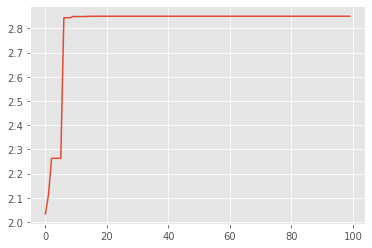

In [ ]:
plt.plot(best_fitness)

In [ ]:
y = xi * np.sin(10 * np.pi * xi) + 1

In [ ]:
pop[0]

[1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0]

In [ ]:
mapear_intervalo(pop[0])

1.8505378805218586